<a href="https://colab.research.google.com/github/ArielFerreiro/ar-stamp-checker/blob/main/attempt.02/01_ImagesBBPreprocesing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook will be used once to resize original images including its bounding boxes in order to train a CNN to detect the label in the image automatically.

In [1]:
%load_ext autoreload
%autoreload 2

#### Load the drive to grab the images and labels

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Notebook Imports

In [16]:
import os
from os import path
import pickle
import albumentations as A
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Use the lates abumentation version (0.5.0) to include BboxParams

In [2]:
A.__version__, cv2.__version__

('0.5.0', '4.4.0')

#### Global Params

In [3]:
images_path = 'drive/My Drive/Colab Notebooks/stamps/original/'
labels_path = 'drive/My Drive/Colab Notebooks/stamps/labels/'
results_path = 'drive/My Drive/Colab Notebooks/stamps/results/'

#### Notebook Functions

In [64]:
def resize(df_original: pd.DataFrame, 
           ruta_imagen: str, 
           size_final: tuple=(224, 224)) -> list:
    """
    :param df_original: pandas DataFrame que contiene las etiquetas en formato COCO
    :param ruta_imagen: str path a la carpeta contenedora de las imagenes originales
    :size_final: tuple indicando el tamaño final deseado
    :return: list contiene los nuevos bounding box de las imagenes que fueron modificadas 
                  y almacenadas en la carpeta destino  
    """
    stamps = []
    bboxes = []
    for index, row in df.iterrows():

        transform = A.Compose([A.Resize(size_final[0], size_final[1], p=1)],
                          bbox_params=A.BboxParams(format='coco', 
                                                    label_fields=['category_ids']),
                              keypoint_params=A.KeypointParams(format='xy')
                          )

        x, y = int(row.x)+1, int(row.y)+1
        w, h = int(row.deltax)+1, int(row.deltay)+1

        image_path = images_path+row.label+"/"+row.file_name

        classe = 0 #genuine
        if row.label[0:3]=='cft':
          classe = 1 #fake
        categorie_ids = [classe]

        if path.exists(image_path):  
            # open image
            img = cv2.imread(image_path, flags=cv2.IMREAD_COLOR)
            img_red = transform(image=img, bboxes=[[x, y, w, h]], 
                                category_ids=categorie_ids,
                                keypoints=[(row.center_x, row.center_y)])
            
            stamps.append(img_red['image'])
            x, y, w, h = img_red['bboxes'][0]
            key_points = img_red['keypoints']
            bb_row = [classe, int(x)+1, int(y)+1, int(w)+1, int(h)+1, 
                      image_path, size_final[0], size_final[1], 
                      key_points[0][0], key_points[0][1]]
            bboxes.append(bb_row)
    return stamps, bboxes

#### Start

In [6]:
with open(results_path+"labels.pkl","rb") as f:
    (df, classes_idx, cant_classes, classes) = pickle.load(f)

In [65]:
stamps, bboxes = resize(df_original=df, ruta_imagen=images_path)

#### Checkpoint

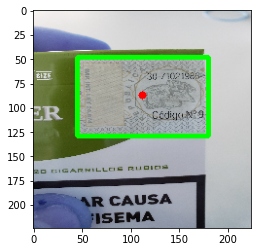

In [67]:
r = [bboxes[0][1], bboxes[0][2], bboxes[0][3], bboxes[0][4]]
i = cv2.rectangle(img=stamps[0], pt1=(int(r[0]), int(r[1])), pt2=(int(r[0]+r[2]), int(r[1]+r[3])), 
                  color=(0, 255, 0), thickness=3)
i = cv2.circle(img=i,center=(int(bboxes[0][8]), int(bboxes[0][9])), color=(255, 0, 0), radius=1, thickness=5)
plt.imshow(i)

#### Save Results in Pickle

In [68]:
stamps_array = np.array(stamps)
bboxes_array = np.array(bboxes)

In [69]:
with open(results_path + "bboxes_224.pkl","wb") as f:
    pickle.dump((stamps_array, bboxes_array), f)

In [ ]:
#### DONE v1 30/10/2020
#### Auth: Ariel Ferreiro / Victor Vivas